<a href="https://colab.research.google.com/github/FappLord/MAI391_Project/blob/main/MAI391_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    roc_curve, auc, classification_report, precision_recall_curve
)
from sklearn.model_selection import train_test_split


sns.set(style="whitegrid")


**IMPORT DATASET**

In [18]:
# Load student exam data
url = "https://raw.githubusercontent.com/FappLord/MAI391_Project/refs/heads/main/student_exam_data.csv"
df = pd.read_csv(url)

# Check dataset dimensions
print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns")

# Display first 5 rows
df.head()

Dataset has 4350 rows and 5 columns


,student_id,study_hours,attendance,past_scores,result
0,1,14.981605,95.084564,7.711228,0
1,2,38.028572,99.547822,6.546507,1
2,3,29.279758,96.348150,1.515951,1
3,4,23.946339,99.098385,8.758831,1
4,5,6.240746,99.996752,5.390946,0


***DATASET INFORMATION***

Target variable distribution:
result
1    2822
0    1528
Name: count, dtype: int64


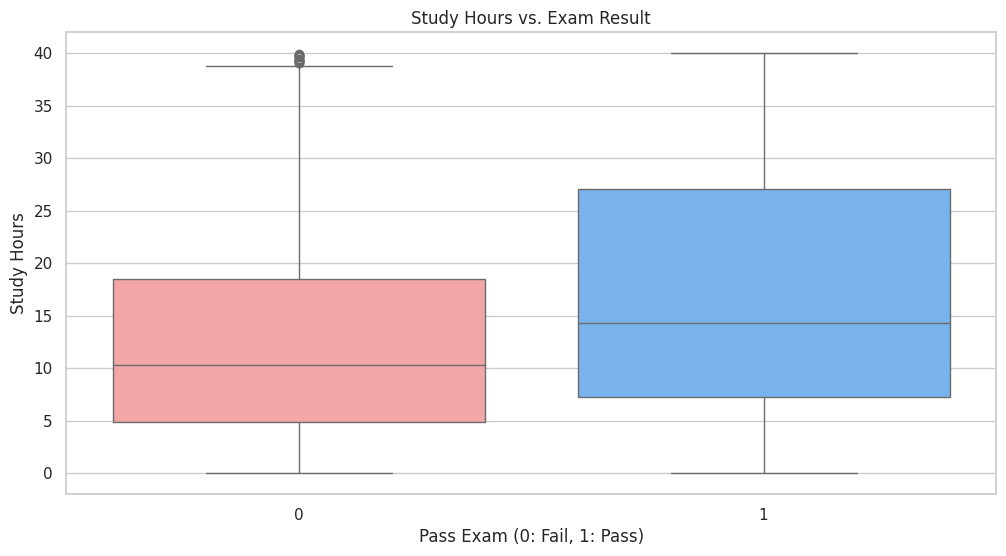

In [19]:
# Check data distribution and balance
print("Target variable distribution:")
print(df['result'].value_counts())

# Visualize feature distributions
plt.figure(figsize=(12, 6))
sns.boxplot(x='result', y='study_hours', data=df, hue="result", palette=["#ff9999", "#66b3ff"], legend=False)
plt.title("Study Hours vs. Exam Result")
plt.xlabel("Pass Exam (0: Fail, 1: Pass)")
plt.ylabel("Study Hours")
plt.show()

In [20]:
print("\n Missing values:")
df.isnull().sum()


 Missing values:


,0
student_id,0
study_hours,0
attendance,0
past_scores,0
result,0


In [21]:
print("\nDescriptive Statistics:")
df.describe()


Descriptive Statistics:


,student_id,study_hours,attendance,past_scores,result
count,4350.000000,4350.000000,4350.000000,4350.000000,4350.000000
mean,2175.500000,15.740430,97.459908,5.000766,0.648736
std,1255.881165,11.472247,1.447837,2.866065,0.477420
min,1.000000,0.000792,95.000789,0.000116,0.000000
25%,1088.250000,6.140560,96.199998,2.529404,0.000000
50%,2175.500000,12.677372,97.426272,5.003190,1.000000
75%,3262.750000,25.035340,98.727249,7.485556,1.000000
max,4350.000000,39.988707,99.997303,9.996732,1.000000


**Data Preprocessing**

In [22]:
# Drop irrelevant columns (if any)
# df.drop(columns=["unnecessary_column"], inplace=True)

# Handle outliers (example for 'study_hours')
def clip_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    return np.clip(data[column], None, upper_bound)

df['study_hours'] = clip_outliers(df, 'study_hours')

# Normalize numerical features
scaler = MinMaxScaler()
numerical_cols = ['study_hours', 'attendance', 'past_scores']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Encode categorical variables (if any)
# df = pd.get_dummies(df, columns=['categorical_column'], drop_first=True)

**Handle Class Imbalance**

In [23]:
X = df.drop(columns=['result'])
y = df['result']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check resampled distribution
print("Resampled class counts:", Counter(y_train_resampled))

Resampled class counts: Counter({0: 2258, 1: 2258})


**Train Logistic Regression Model**

In [24]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluate model
print("\n--- Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.3f}")


--- Model Evaluation ---
Accuracy: 0.791
Precision: 0.852
Recall: 0.819
F1-Score: 0.835


**Visualization**

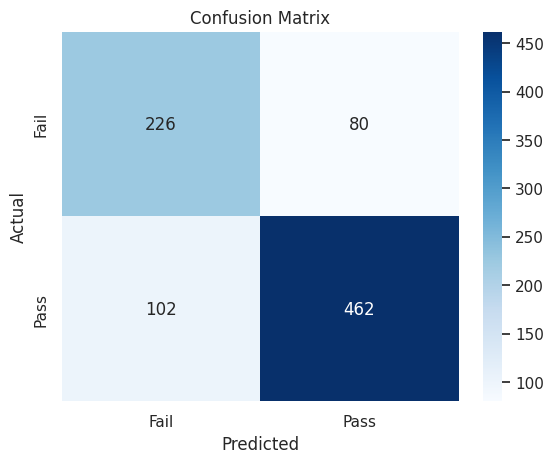

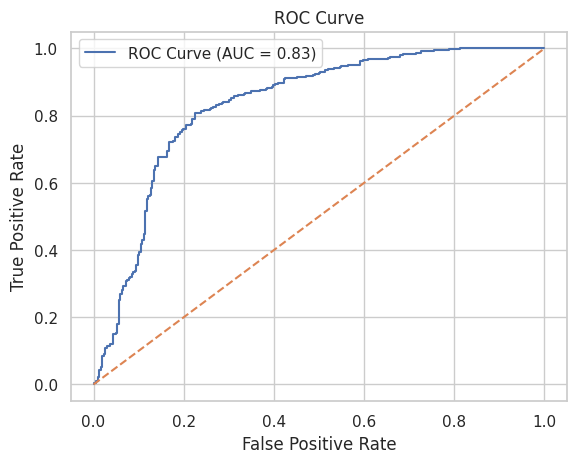

In [25]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Fail", "Pass"], yticklabels=["Fail", "Pass"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()